# Data Analysis using __PySpark__  
*Fun with the __MovieLens__ dataset*  

**Part 4: Data Analysis using ratings.csv from the MovieLens dataset**

<font color='green'>__Support for Google Colab__  </font>

<font color='green'>uncomment and execute the cell below to setup and run this Spark notebook on Google Colab.</font>

In [1]:
# SETUP FOR COLAB: select all the lines below and uncomment (CTRL+/ on windows)

# # grab spark
# # as of 2023-06-23, the latest version is 3.4.1, get the link from Apache Spark's website
# ! wget -q https://dlcdn.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
# # unzip spark
# !tar xf spark-3.4.1-bin-hadoop3.tgz
# # install findspark package
# !pip install -q findspark
# # Let's download and unzip the MovieLens 25M Dataset as well.
# ! mkdir ./data
# ! wget -q https://files.grouplens.org/datasets/movielens/ml-25m.zip
# ! unzip ./ml-25m.zip -d ./data/

# # got to provide JAVA_HOME and SPARK_HOME vairables
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop3.2"

## Start the local/colab Spark Cluster

In [2]:
# Step 1: initialize findspark
import findspark

findspark.init()

# Step 2: import pyspark
import pyspark
from pyspark.sql import SparkSession

print(pyspark.__version__)

# Step 3: Create a spark session
#     using local[*] to use as many logical cores as available, use 1 when in doubt
#     'local[1]' indicates spark on 1 core on the local machine or specify the number of cores needed
#     use .config("spark.some.config.option", "some-value") for additional configuration

spark = (
    SparkSession.builder.master("local[*]")
    .appName("Analyzing Movielens Data")
    .getOrCreate()
)

# spark

3.4.1


# Problem Set 3  - ```ratings.csv```

1. Find number of films for each rating, so number of films that have at least one rating of 1, number of films that have at least one rating of 2 and so on...  

1. List user-IDs in order of number of films they have rated, descending.  

1. Are there users who have given multiple ratings to the same film?  

## Load Movies data from the MovieLens dataset

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

#
datalocation = "../data/ml-25m/"
file_path_ratings = datalocation + "ratings.csv"
#
schema_ratings = StructType(
    [
        StructField("userId", StringType(), False),
        StructField("movieId", StringType(), False),
        StructField("rating", FloatType(), True),
        StructField("timestamp", StringType(), True),
    ]
)
#
ratings_raw = (
    spark.read.format("csv")
    .option("encoding", "UTF-8")
    .option("header", True)
    .option("sep", ",")
    .option("escape", '"')
    .schema(schema_ratings)
    .load(file_path_ratings)
)

In [4]:
ratings_raw.show(10, False)

+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |296    |5.0   |1147880044|
|1     |306    |3.5   |1147868817|
|1     |307    |5.0   |1147868828|
|1     |665    |5.0   |1147878820|
|1     |899    |3.5   |1147868510|
|1     |1088   |4.0   |1147868495|
|1     |1175   |3.5   |1147868826|
|1     |1217   |3.5   |1147878326|
|1     |1237   |5.0   |1147868839|
|1     |1250   |4.0   |1147868414|
+------+-------+------+----------+
only showing top 10 rows



## Solutions to Problem Set 3

### Find number of films for each rating

* so number of films that have at least one rating of 1, number of films that have at least one rating of 2 and so on...

In [5]:
# to refresh, here's what ratings data looks like
ratings_raw.show(10)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
+------+-------+------+----------+
only showing top 10 rows



In [6]:
absolute_freq_ratings = ratings_raw.groupBy("rating").count()

In [7]:
absolute_freq_ratings.orderBy(col("count").desc()).show()

+------+-------+
|rating|  count|
+------+-------+
|   4.0|6639798|
|   3.0|4896928|
|   5.0|3612474|
|   3.5|3177318|
|   4.5|2200539|
|   2.0|1640868|
|   2.5|1262797|
|   1.0| 776815|
|   1.5| 399490|
|   0.5| 393068|
+------+-------+



In [8]:
# setup matplotlib before starting plotting
import matplotlib.pyplot as plt

# jupyter mpl magic
%matplotlib inline

# note: in case you want to use the widget or notebook magic:
# ensure that ipympl is also installed.
# there may be other steps involved as well
# for e.g. widget works based on nodeJS, so you'll have to config/enable that too

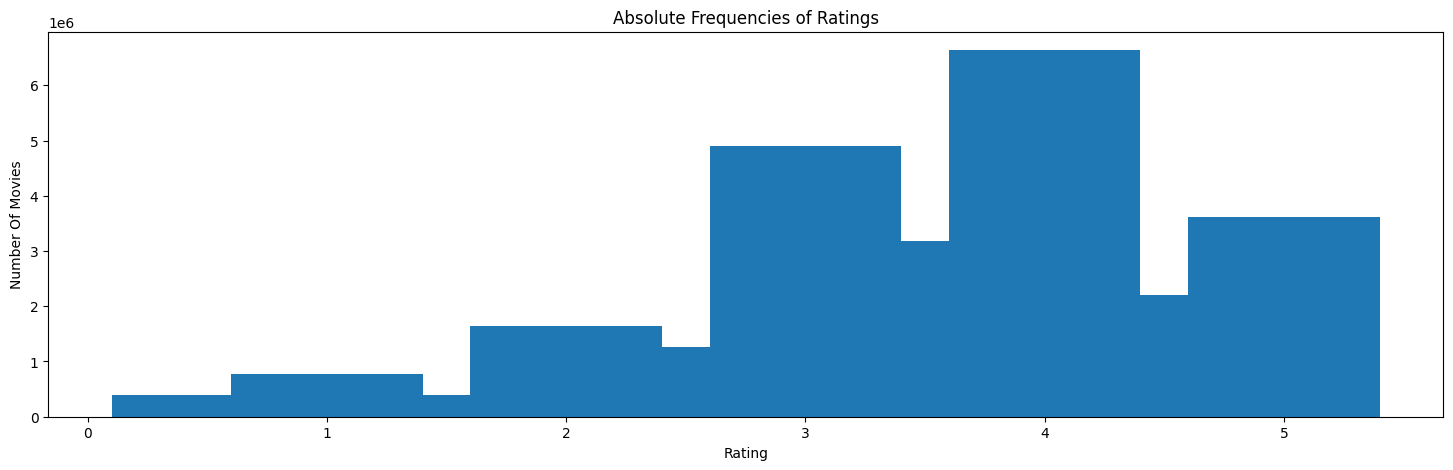

In [9]:
# convert each column to a list
absolute_freq_ratings_x = (
    absolute_freq_ratings.select(col("rating")).rdd.flatMap(lambda x: x).collect()
)
absolute_freq_ratings_y = (
    absolute_freq_ratings.select(col("count")).rdd.flatMap(lambda x: x).collect()
)

plt.figure(figsize=(18, 5))
plt.bar(absolute_freq_ratings_x, absolute_freq_ratings_y)
plt.title("Absolute Frequencies of Ratings")
plt.xlabel("Rating")
plt.ylabel("Number Of Movies")
plt.show()

### List user-IDs in order of number of films they have rated, descending

In [10]:
rating_freq_by_user = ratings_raw.groupBy("userId").count()

In [11]:
rating_freq_by_user.orderBy(col("count").desc()).show()

+------+-----+
|userId|count|
+------+-----+
| 72315|32202|
| 80974| 9178|
|137293| 8913|
| 33844| 7919|
| 20055| 7488|
|109731| 6647|
| 92046| 6564|
| 49403| 6553|
| 30879| 5693|
|115102| 5649|
|110971| 5633|
| 75309| 5525|
| 78849| 5276|
| 61010| 5244|
| 29803| 5219|
|122011| 5160|
| 57548| 5066|
| 93855| 5045|
|103611| 4861|
| 34987| 4831|
+------+-----+
only showing top 20 rows



In [12]:
rating_freq_by_user.count()

162541

That's a lot of ratings by a lot of users...  

Some of these like ```72315``` def seem like a bot - or a human whose spent a lot of time regularly watching films - if we estimate a film to be 90 minutes on an average, it comes to about 48303 hours - that's like 5.5 years of 24/7 movie-watching! In practice this would've taken the person 8-10 times longer (considering 3 hours of movies daily - no holidays) - so 44 to 55 years of movies... - yeah, I'll bet this was some automated thing



### Are there users who have given multiple ratings to the same film?

In [13]:
usr_movie_count = ratings_raw.groupBy("userId", "movieId").count()

In [14]:
usr_movie_count.orderBy(col("count").asc()).show(10)

+------+-------+-----+
|userId|movieId|count|
+------+-------+-----+
|     1|   1088|    1|
|     3|   3646|    1|
|     1|   1175|    1|
|     3|  70286|    1|
|     1|   2012|    1|
|     3|  91658|    1|
|     1|   1250|    1|
|     3| 122882|    1|
|     1|   2068|    1|
|     3| 122906|    1|
+------+-------+-----+
only showing top 10 rows



Doesn't seem like users have rated the same movie multiple times.
*[think]* is there another way to confirm this?

# Clear cache and stop the spark cluster

In [15]:
# clear cache
spark.catalog.clearCache()

In [16]:
# stop spark
spark.stop()

# Insights

We are practicing some of the same stuff, however ```ratings``` is a substantially larger dataset - we need to be more careful with joins etc.

# Next

We continue our data analysis exercises with multiple data files loaded.